* [x] ignore illegal action
* [x] penalize revisiting states
* [x] penalize too many steps
* [x] net use cov, output depends on input
* agent: 
* * [x] DQL
* * [ ] A3C
* * [x] REINFORCE
* loss? measure performance? optimal path? 
* train with sizes X, test on sizes Y
------------------------------
* https://github.com/Taospirit/DRL-with-pytorch
* https://lilianweng.github.io/posts/2018-02-19-rl-overview
* https://spinningup.openai.com/en/latest/spinningup/keypapers.html

* https://boring-guy.sh/posts/masking-rl/
* https://datascience.stackexchange.com/questions/61536/deep-reinforcement-learning-on-changing-data-sizes
------------------------------

* loss is much more well-behaved after embedding!
* only 6 playable config with 342.. how to make model generalize better?
* how to penalize loops?
* how to find optimal steps?
* reward enjineering is very important!!!

In [15]:
import random
import copy
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import gym
from gym import spaces

from config_3_4_2 import config_3_4_2

In [97]:
class Board:
    def __init__(self, num_color: int, max_length: int, empty: int = 2):
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.flasks = np.full((self.tubes, self.max_length), -1, dtype=np.int16)

        self.idx = np.zeros(self.tubes, dtype=np.uint16)
        self.idx[:self.num_color] = self.max_length

        self.actions = []
        self.states = set()

    def __str__(self):
        return str(self.flasks)

    def __repr__(self):
        return str(self.flasks)

    def __iter__(self):
        return iter(self.flasks)

    def __len__(self):
        return len(self.flasks)

    def __getitem__(self, item):
        return self.flasks[item]

    def grid_to_state(self) -> List[List[int]]:
        state = []
        for r in self:
            state.append([])
            for c in r:
                if c != -1:
                    state[-1].append(c)
        return state

    def state_to_grid(self, state: List[List[int]]):
        self.flasks.fill(-1)
        self.idx.fill(0)
        self.actions = []
        self.states = set()
        for i, r in enumerate(state):
            self.idx[i] = len(r)
            for j, c in enumerate(r):
                self.flasks[i][j] = c

    def is_flask_full(self, i: int) -> bool:
        return self.idx[i] == self.max_length

    def is_flask_empty(self, i: int) -> bool:
        return self.idx[i] == 0

    def has_one_color(self, i: int) -> bool:
        if self.idx[i] == 0:
            return True
        return (self.flasks[i][:self.idx[i]] == self.flasks[i][0]).all()

    def is_flask_solved(self, i: int) -> bool:
        if self.is_flask_empty(i) or (self.is_flask_full(i) and self.has_one_color(i)):
            return True
        return False

    def top(self, i: int) -> int:
        return self.flasks[i][self.idx[i]-1]

    def pop(self, i: int) -> int:
        ball = self.flasks[i][self.idx[i]-1]
        self.flasks[i][self.idx[i] - 1] = -1
        self.idx[i] -= 1
        return ball

    def push(self, i: int, ball: int):
        self.flasks[i][self.idx[i]] = ball
        self.idx[i] += 1

    def is_push_allowed(self, i: int, ball: int) -> bool:
        if self.is_flask_empty(i) or (self.top(i) == ball and not self.is_flask_full(i)):
            return True
        return False

    def is_invalid_init_state(self) -> bool:
        return any(self.is_flask_full(i) and self.has_one_color(i) for i in range(self.tubes))

    def is_solved(self) -> bool:
        return all(self.is_flask_solved(i) for i in range(self.tubes))

    def reward(self) -> int:
        if self.is_solved():
            return 10 * self.max_length * self.num_color + 100
        if str(self) in self.states:
            return -10
        return sum(10 * int(self.has_one_color(i)) * self.idx[i] for i in range(self.tubes))

    def valid_actions(self) -> List[Tuple[int, int]]:
        actions = []
        for i in range(self.tubes):
            if self.is_flask_solved(i):
                continue
            if self.is_flask_empty(i):
                continue
            top_i = self.top(i)
            for j in range(self.tubes):
                if i != j and self.is_push_allowed(j, top_i):
                    actions.append((i, j))
        return actions

    def play(self, action: Tuple[int, int]):
        self.push(action[1], self.pop(action[0]))
        self.actions.append(action)

    def undo_action(self):
        action = self.actions.pop()
        self.push(action[0], self.pop(action[1]))

    def dfs_solve(self, steps: int = 0, path: List["Board"] = []) -> Tuple[bool, int, List["Board"]]:
        if self.is_solved():
            return True, steps, path
        if steps >= 1000:
            return False, steps, path
        for a in self.valid_actions():
            self.play(a)
            current_state = str(self)
            if current_state in self.states:
                self.undo_action()
                continue
            self.states.add(current_state)
            path.append(copy.deepcopy(self))
            r = self.dfs_solve(steps+1)
            if r[0]:
                return r
            self.undo_action()
        return False, steps, path

In [3]:
class BallSort(gym.Env):

    metadata = {"render_modes": ["human", "silent", "cli"]}

    cmap = colors.ListedColormap(['#000000', '#e4572e', '#1b998b', '#29335c', '#f3a712', '#669bbc', '#ed217c', '#58355e', '#f39c6b', '#ca907e', '#aeb7b3', '#c0b9dd', '#a8c686'])

    def __init__(self, num_color: int = 3, max_length: int = 4, empty: int = 2):
        super(BallSort, self).__init__()
        self.env_name = 'ball-sort-puzzle'
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty

        self.arr = np.array(list(range(num_color)) * max_length).reshape(num_color, max_length)
        self.board = Board(self.num_color, self.max_length, self.empty)
        self.steps = 0

        self.data = set()

        self.action_space = spaces.Box(low=0, high=self.tubes - 1, shape=(2,), dtype=int)
        self.observation_space = spaces.Box(low=-1, high=self.num_color-1, shape=(self.tubes, self.max_length), dtype=int)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        """make an env"""
#         solvable = False
#         temp_board = Board(self.num_color, self.max_length, self.empty)
#         while not solvable:
#             np.random.shuffle(self.arr)
#             temp_board.state_to_grid(self.arr.tolist())
#             if not temp_board.is_invalid_init_state() and str(temp_board) not in self.data:
#                 self.data.add(str(temp_board))
#                 solvable, steps, path = temp_board.dfs_solve()

#         self.board.state_to_grid(self.arr.tolist())
#         self.render()

        """load from file"""
        self.board.state_to_grid(random.choice(config_3_4_2))
        steps = 0
        self.render()
        return self.board.flasks, steps

    def step(self, action: Tuple[int, int]):
        assert action in self.board.valid_actions(), "action must be playable!!"
        self.board.play(action)
        self.steps += 1
        reward = self.board.reward()
        solved = self.board.is_solved()
        self.board.states.add(str(self.board))
        self.render(reward)

        return self.board.flasks, reward, solved, {"steps": self.steps}

    def render(self, reward=None):
        if self.render_mode == "cli":
            print("====================================================")
            print("Step:", self.steps)
            print(self.board.grid_to_state())
            print("State Reward:", reward if reward else self.board.reward())
            print("Is solved:", self.board.is_solved())
            print("====================================================")
        elif self.render_mode == "human":
            # plt.figure(figsize=(self.tubes, self.max_length))
            plt.imshow(self.board.flasks.T[::-1], cmap=self.cmap)
            plt.title(f"Step: {self.steps}. Reward: {reward if reward else self.board.reward()}. Solved: {self.board.is_solved()}")
            plt.axis("off")
            plt.show()

In [16]:
class Model(nn.Module):
    def __init__(self, num_color, max_length, empty, p=0.2, is_prob=False):
        super().__init__()
        # max 12 balls + 1 for empty
        self.em = nn.Embedding(num_embeddings=num_color+1, embedding_dim=3, padding_idx=0)
        self.cnn = [nn.Conv2d(3, 16, (3, 1))]
        self.bn = [nn.BatchNorm2d(16)]
        self.drop = nn.Dropout(p=p)
        self.mp = nn.MaxPool2d(2)
        self.flat = nn.Flatten()

        flat_shape = 16 * ((num_color + empty - 2) // 2) * (max_length // 2)
        log_2 = int(np.ceil(np.log2(flat_shape)))
        # print(flat_shape, log_2)
        self.fc = [nn.Linear(flat_shape, 2 ** (log_2 + 2)), nn.Linear(2 ** (log_2 + 2), 2 ** (log_2 + 1))]
        self.out = nn.Linear(2 ** (log_2 + 1), (num_color + empty) ** 2)
        self.is_prob = is_prob

    def forward(self, x, mask=None):
        # print(x.size())
        x = self.em(x+1)
        # print(x.size())
        x = x.permute(0, 3, 1, 2)
        # print(x.size())

        for i in range(len(self.cnn)):
            x = self.cnn[i](x)
            x = self.bn[i](x)
            x = F.relu(x)
            # print(x.size())
            x = self.mp(x)
            x = self.drop(x)
            # print(x.size())

        x = self.flat(x)
        # print(x.size())
        for i in range(len(self.fc)):
            x = self.fc[i](x)
            x = F.relu(x)
            # print(x.size())
        x = self.out(x)
        # print(x.size())

        if mask is not None:
            x[mask] = -np.inf
        if self.is_prob:
            x = F.softmax(x, dim=1)
        return x

In [42]:
class Agent:
    def __init__(self, num_color, max_length, empty, epsilon, gamma, lr, device):
        self.device = device
        # env set up
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.num_actions = self.tubes * self.tubes
        self.num_states = self.tubes * self.max_length

        self.env = BallSort(self.num_color, self.max_length, self.empty)

        # reinforcement learning
        self.epsilon = epsilon
        self.gamma = gamma

        # neural network
        self.lr = lr

    def get_mask(self):
        allowed_actions = self.env.board.valid_actions()
        allowed_actions_linear = [i * self.tubes + j for i, j in allowed_actions]
        mask = torch.ones(self.num_actions, dtype=bool).to(self.device)
        mask[allowed_actions_linear] = False
        return mask

    def choose_action(self, state, evaluation=False):
        return

    def learn(self):
        return

    def train(self, episodes=500, dfs_steps=0, plot=False):
        return

    def evaluate(self, state=None, render=False):
        if render:
            self.env.render_mode = "human"
        if state is None:
            state, dfs_steps = self.env.reset()

        states = []
        self.eval_net.eval()
        with torch.no_grad():
            ep_reward = 0
            done = False
            while not done:
                states.append(copy.deepcopy(state))

                state = torch.LongTensor(state).to(self.device)
                action, _ = self.choose_action(state, True)

                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                state = next_state
            states.append(state)
        return states, ep_reward, info["steps"], dfs_steps

In [43]:
class DQN(Agent):
    def __init__(self, num_color, max_length, empty, epsilon, gamma, lr, device, delta, batch_size, memory_capacity, q_network_iteration):
        super().__init__(num_color, max_length, empty, epsilon, gamma, lr, device)

        # buffer replay set up
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.q_network_iteration = q_network_iteration
        self.learn_step_counter = 0
        self.memory_counter = 0

        # state, action, reward, next state, mask
        # self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2 + self.num_actions)) 
        self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2)) 

        # neural network
        self.eval_net = Model(self.num_color, self.max_length, self.empty).to(self.device)
        self.target_net = Model(self.num_color, self.max_length, self.empty).to(self.device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.delta = delta
        self.criterion = torch.nn.HuberLoss(delta=self.delta).to(self.device)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def choose_random_valid_action(self):
        allowed_actions = self.env.board.valid_actions()
        return random.choice(allowed_actions), self.get_mask()

    def choose_random_action(self):
        action = random.randint(0, self.num_actions-1)
        i = action // (self.tubes)
        j = action % (self.tubes)
        action = (i, j)
        return action

    def choose_best_valid_action(self, state):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0))
            action_probs[:, mask] = -np.inf
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action, mask

    def choose_best_action(self, state):
        with torch.no_grad():
            action_probs = self.eval_net(state.unsqueeze(0))
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action

    def choose_action(self, state, evaluation=False):
        if evaluation:
            return self.choose_best_valid_action(state)
        else:
            if np.random.randn() < self.epsilon:
                return self.choose_random_valid_action()
            else:
                return self.choose_best_valid_action(state)

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state.view(-1).cpu().numpy(),
                                [action, reward],
                                # mask.view(-1).cpu().numpy(),
                                next_state.reshape(-1)))
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # update the parameters
        if self.learn_step_counter % self.q_network_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.LongTensor(batch_memory[:, :self.num_states]).view(self.batch_size, self.tubes, self.max_length).to(self.device)
        batch_action = torch.LongTensor(batch_memory[:, self.num_states:self.num_states+1]).to(self.device)
        batch_reward = torch.FloatTensor(batch_memory[:, self.num_states+1:self.num_states+2]).to(self.device)
        # batch_mask = torch.tensor(batch_memory[:, self.num_states+2:self.num_states+2+self.num_actions], dtype=torch.bool).to(self.device)
        batch_next_state = torch.LongTensor(batch_memory[:, -self.num_states:]).view(self.batch_size, self.tubes, self.max_length).to(self.device)

        # q_eval
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1)

        loss = self.criterion(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=500, plot=False):
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        for i in range(1, episodes+1):
            self.epsilon = max(0, 0.9*(1-(i)/100))
            state, dfs_steps = self.env.reset()
            ep_reward = 0
            done = False
            loss = []
            while not done:
                state = torch.LongTensor(state).to(self.device)
                action, _ = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.store_transition(state, action[0] * self.tubes + action[1], reward, next_state)
                ep_reward += reward

                if self.memory_counter >= self.memory_capacity:
                    loss.append(self.learn())
                state = next_state
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            loss_list.append(np.mean(loss))
            if plot and ((i) % 50 == 0 or i == episodes):
                print(f"Episode: {i}, Steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {np.mean(loss)}, eps: {self.epsilon}")
                fig, ax = plt.subplots(3)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                plt.show()

        return reward_list, step_list, loss_list

In [44]:
class REINFORCE(Agent):

    def __init__(self, num_color, max_length, empty, epsilon, gamma, lr, device):
        super().__init__(num_color, max_length, empty, epsilon, gamma, lr, device)

        # memory
        self.saved_log_probs = []
        self.rewards = []

        # neural network
        self.eval_net = Model(self.num_color, self.max_length, self.empty, is_prob=True).to(self.device)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def choose_action(self, state, evaluation=False):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0), mask.unsqueeze(0))
            m = Categorical(action_probs)
            action = m.sample()
            if not evaluation:
                self.saved_log_probs.append(m.log_prob(action))
            action = action.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action, mask

    def learn(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards, requires_grad=True)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.epsilon)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        self.saved_log_probs = []
        self.rewards = []

        return policy_loss.item()

    def train(self, episodes=500, plot=False):
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []

        for i in range(1, episodes+1):
            state, dfs_steps = self.env.reset()
            ep_reward = 0
            done = False
            while not done:
                state = torch.LongTensor(state).to(self.device)
                action, _ = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.rewards.append(reward)
                ep_reward += reward
                state = next_state

            loss = self.learn()
            loss_list.append(loss)
            step_list.append(info['steps'])
            reward_list.append(ep_reward)

            if plot and ((i) % 50 == 0 or i == episodes):
                print(f"Episode: {i}, Steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {loss}")
                fig, ax = plt.subplots(3)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                plt.show()

        return reward_list, step_list, loss_list

/home/alghra0e/rl/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alghra0e/rl/env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 50, Steps: 41, dfs_steps: 0, reward: 2470, loss 53.329994201660156, eps: 0.45


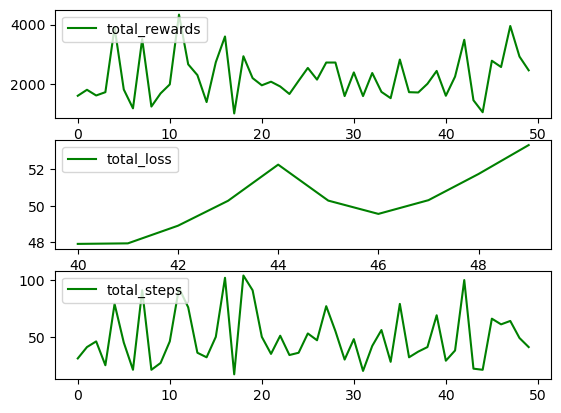

Episode: 100, Steps: 21, dfs_steps: 0, reward: 1160, loss 50.57910592215402, eps: 0


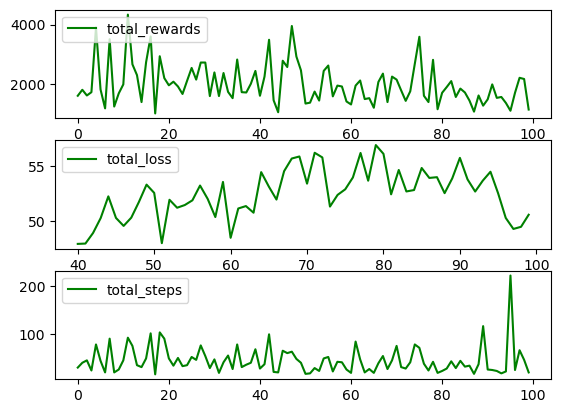

Episode: 150, Steps: 41, dfs_steps: 0, reward: 2070, loss 44.824459634176115, eps: 0


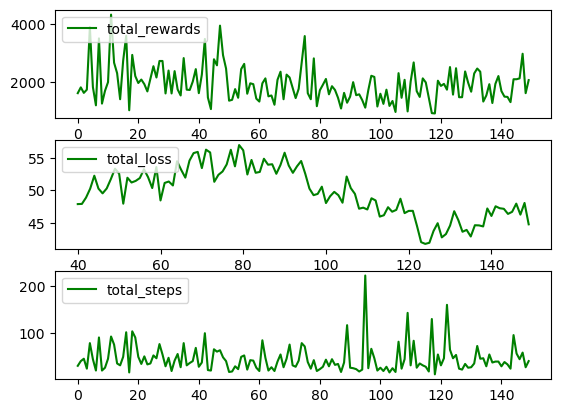

Episode: 200, Steps: 22, dfs_steps: 0, reward: 1770, loss 55.46340959722345, eps: 0


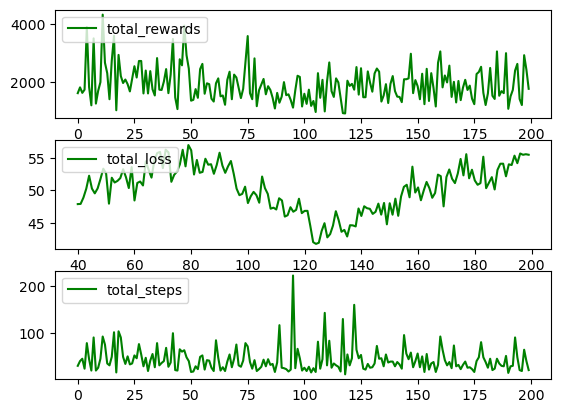

In [32]:
# hyper-parameters

NUM_COLOR = 3
MAX_LENGTH = 4
EMPTY = 2

EPSILON = 0.99 # np.finfo(np.float32).eps.item()

BATCH_SIZE = 32
MEMORY_CAPACITY = 2000
Q_NETWORK_ITERATION = 100

LR = 0.0001
DELTA = 1.0
GAMMA = 0.99

EPISODES = 200

DEVICE = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 100
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

dqn = DQN(NUM_COLOR, MAX_LENGTH, EMPTY, EPSILON, GAMMA, LR, DEVICE, DELTA, BATCH_SIZE, MEMORY_CAPACITY, Q_NETWORK_ITERATION)
reward_list, step_list, loss_list = dqn.train(EPISODES, True)

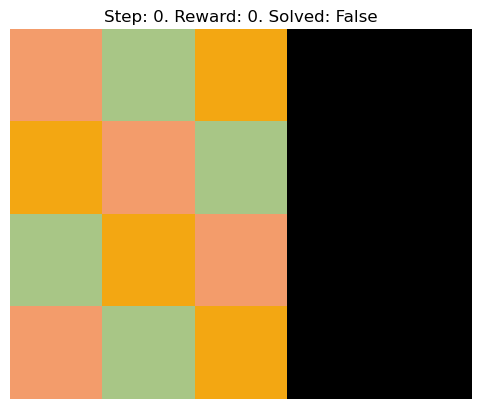

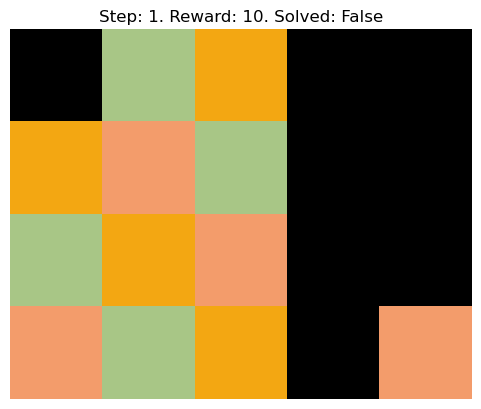

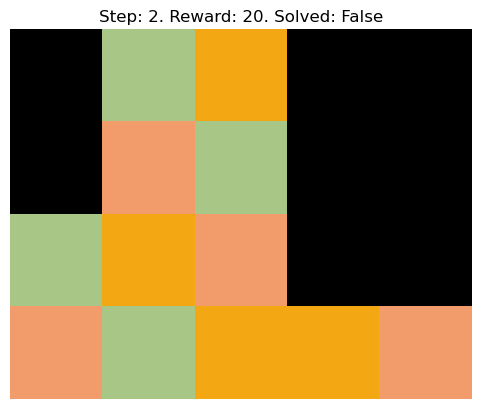

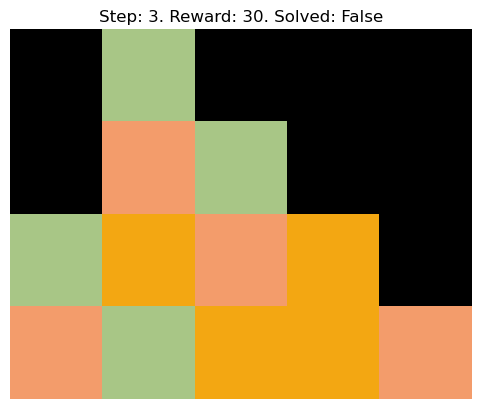

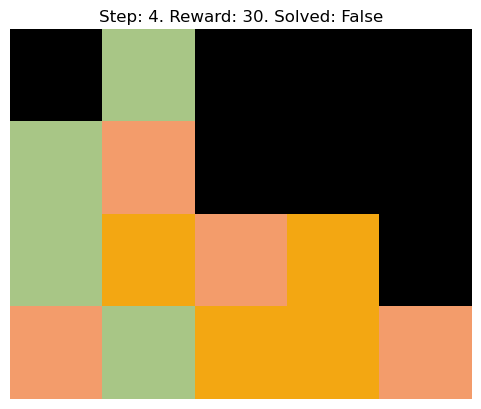

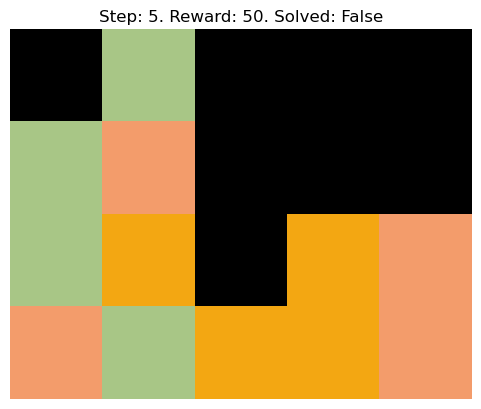

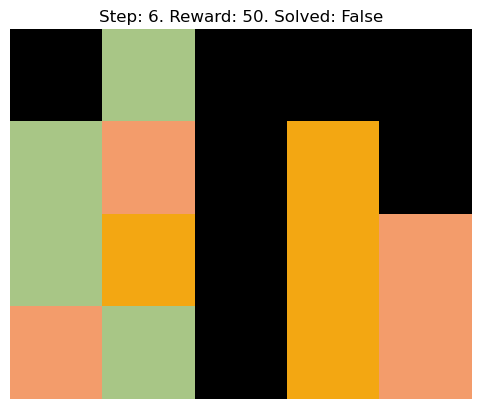

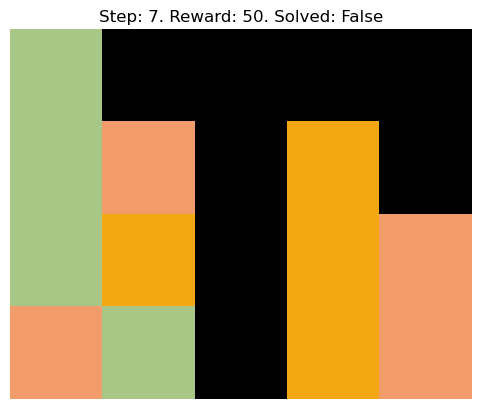

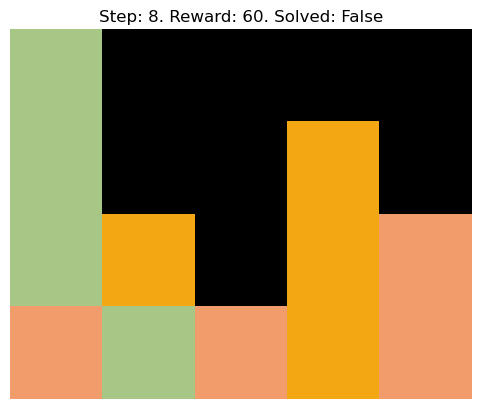

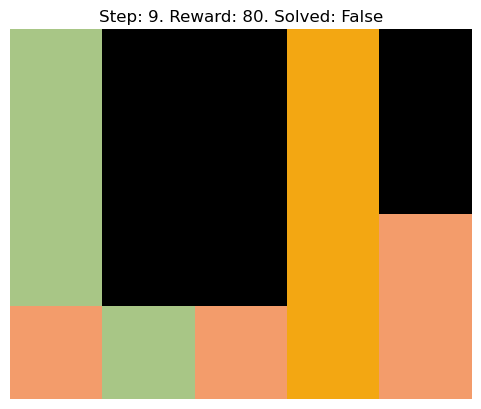

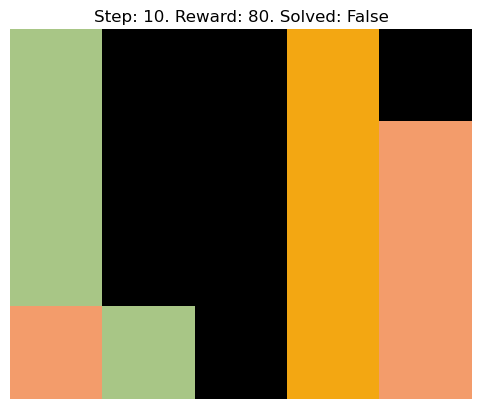

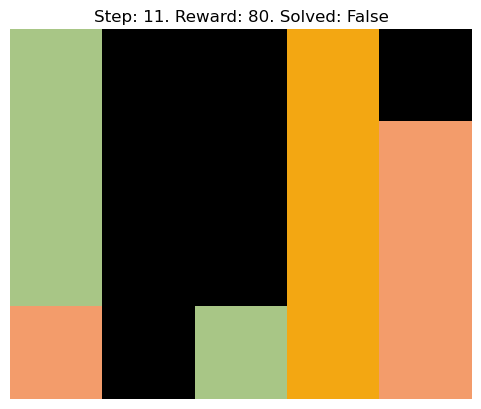

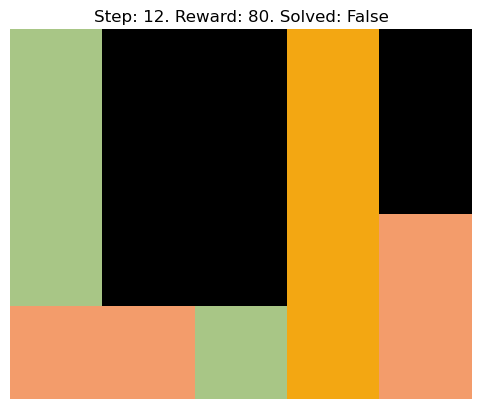

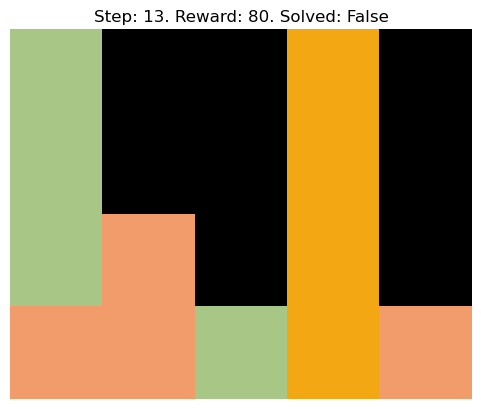

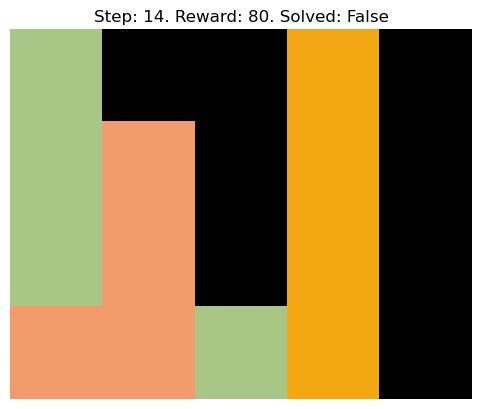

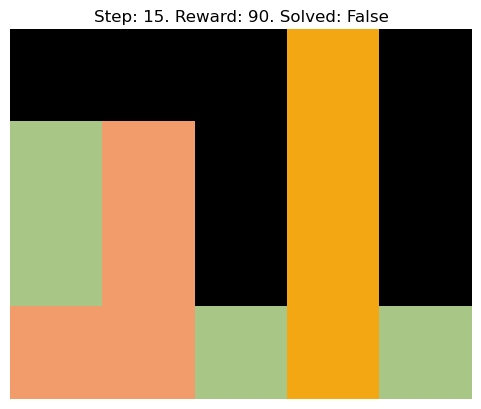

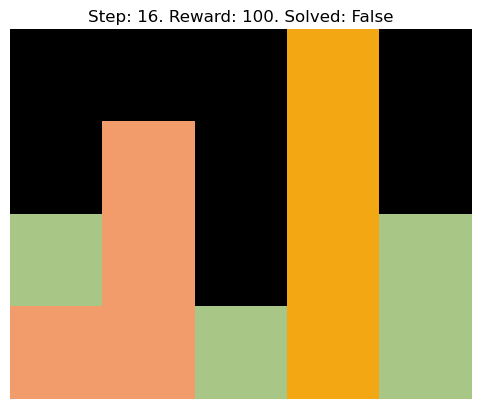

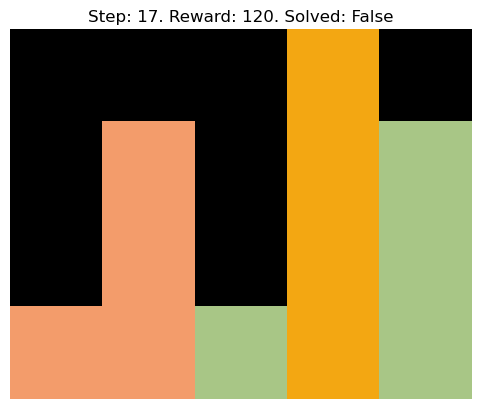

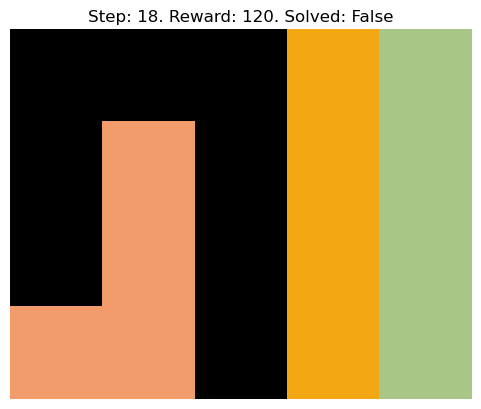

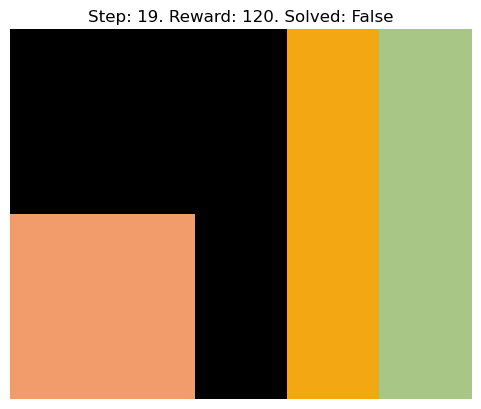

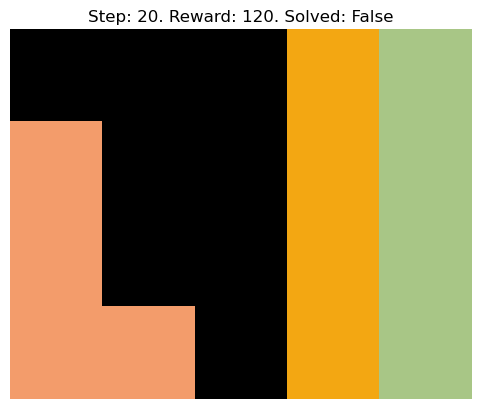

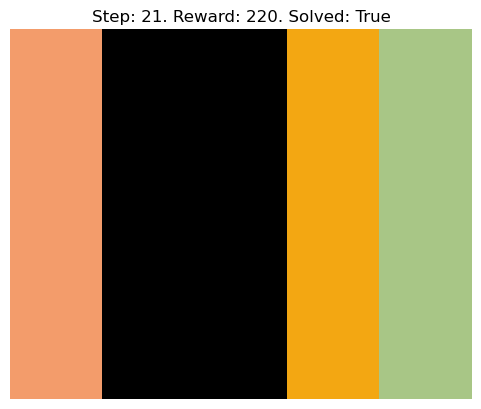

([array([[ 1,  2,  0,  1],
         [ 2,  0,  1,  2],
         [ 0,  1,  2,  0],
         [-1, -1, -1, -1],
         [-1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0, -1],
         [ 2,  0,  1,  2],
         [ 0,  1,  2,  0],
         [-1, -1, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2, -1, -1],
         [ 2,  0,  1,  2],
         [ 0,  1,  2,  0],
         [ 0, -1, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2, -1, -1],
         [ 2,  0,  1,  2],
         [ 0,  1,  2, -1],
         [ 0,  0, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  2, -1],
         [ 2,  0,  1,  2],
         [ 0,  1, -1, -1],
         [ 0,  0, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  2, -1],
         [ 2,  0,  1,  2],
         [ 0, -1, -1, -1],
         [ 0,  0, -1, -1],
         [ 1,  1, -1, -1]], dtype=int16),
  array([[ 1,  2,  2, -1],
         [ 2,  0,  1,  2],
         [-1, -1, -1, -1],
         [ 0,  0,  

In [33]:
dqn.evaluate(True)

Episode: 50, Steps: 57, dfs_steps: 0, reward: 1980, loss -2.4293930530548096


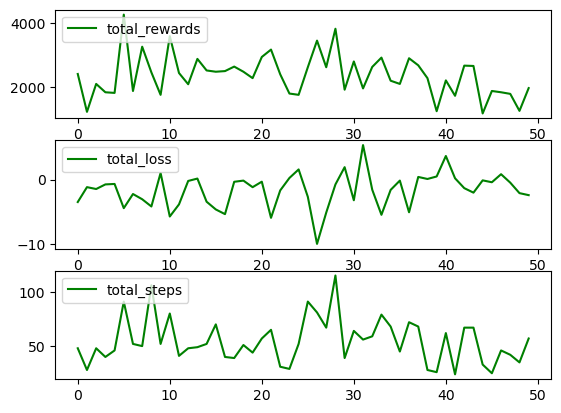

Episode: 100, Steps: 96, dfs_steps: 0, reward: 3050, loss -9.20831298828125


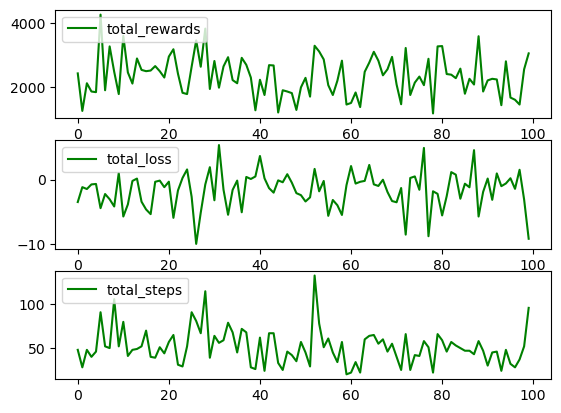

Episode: 150, Steps: 57, dfs_steps: 0, reward: 2310, loss -1.0171713829040527


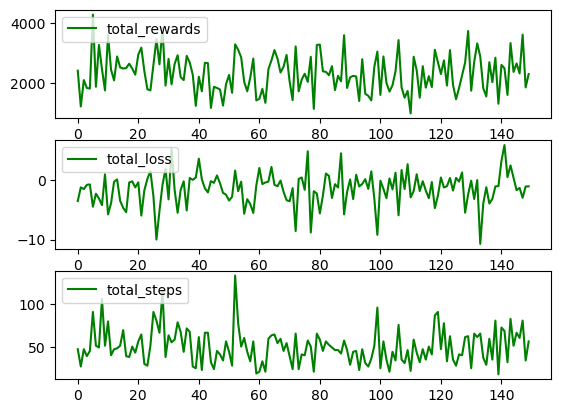

Episode: 200, Steps: 35, dfs_steps: 0, reward: 2190, loss -4.098077774047852


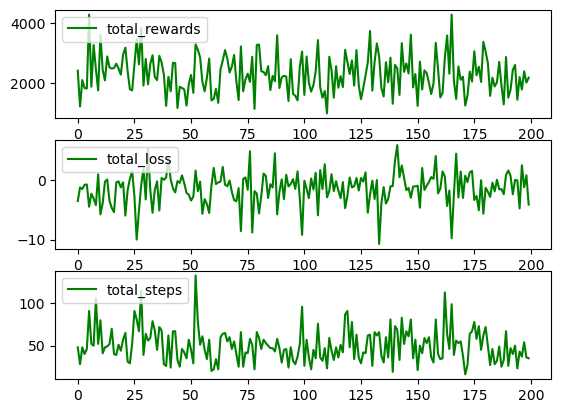

In [40]:
EPSILON = np.finfo(np.float32).eps.item()
pg = REINFORCE(NUM_COLOR, MAX_LENGTH, EMPTY, EPSILON, GAMMA, LR, DEVICE)
reward_list, step_list, loss_list = pg.train(EPISODES, True)

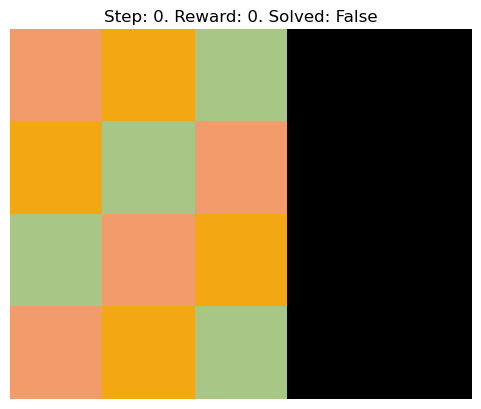

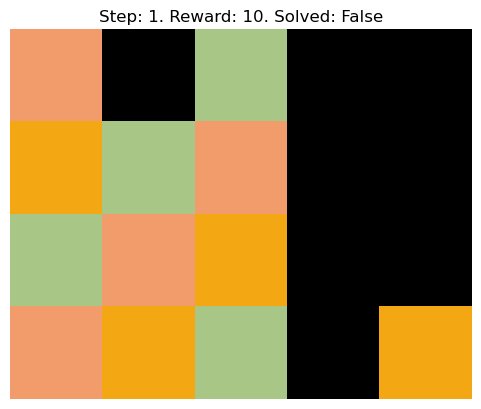

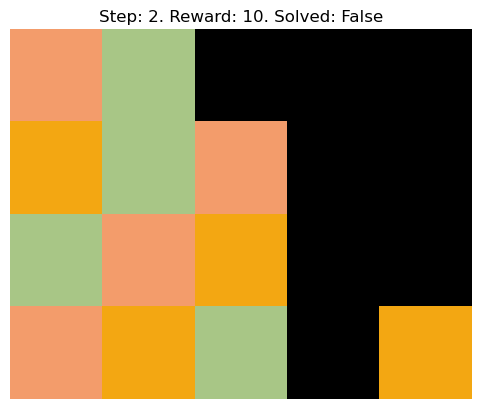

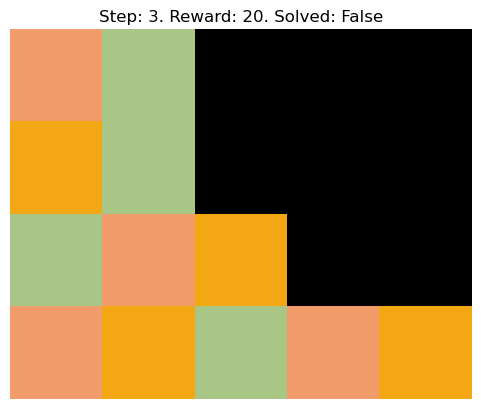

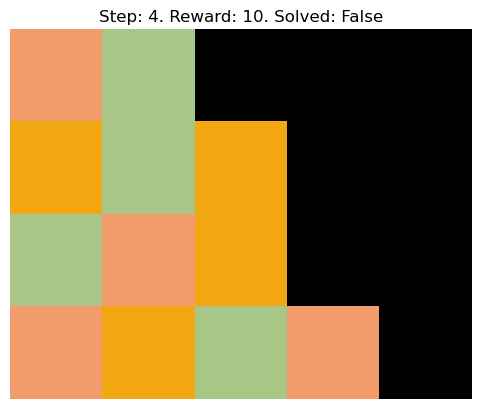

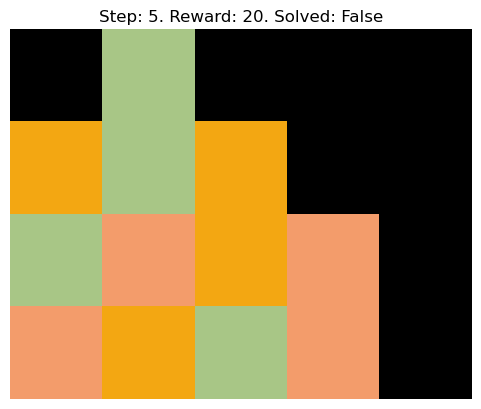

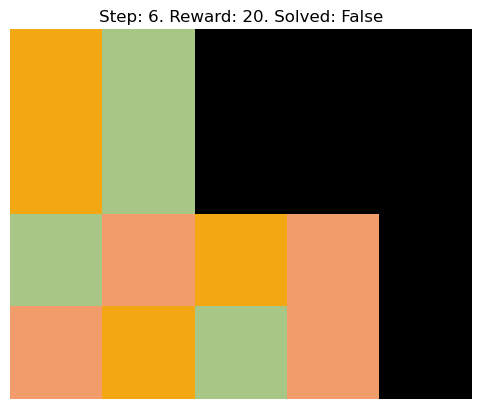

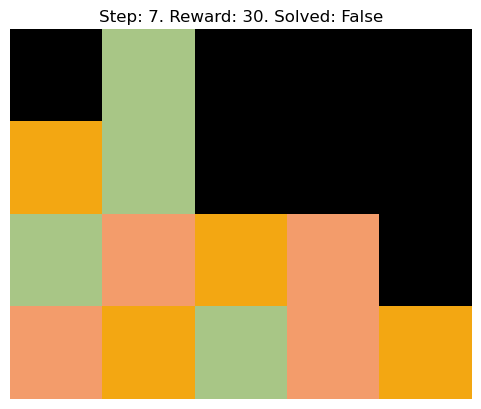

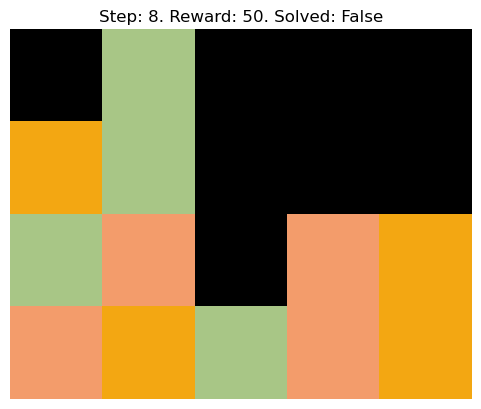

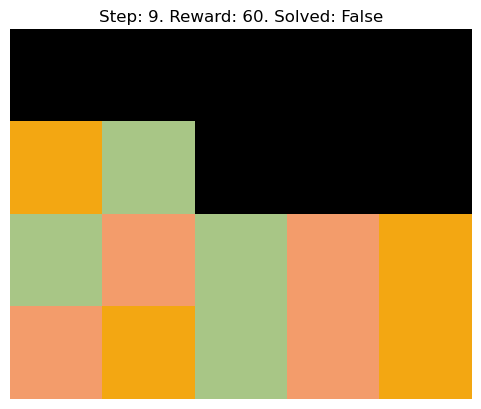

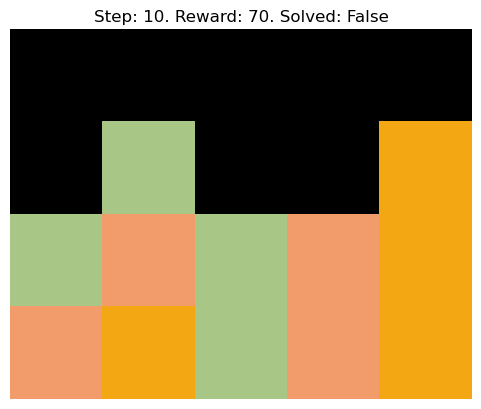

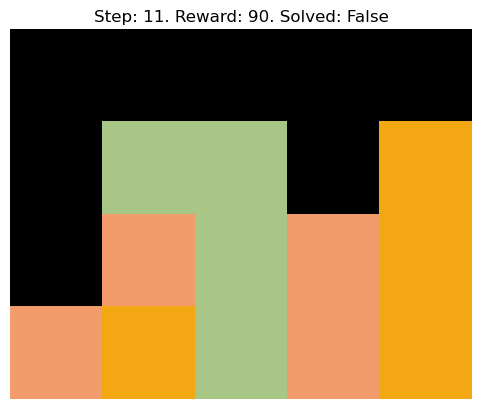

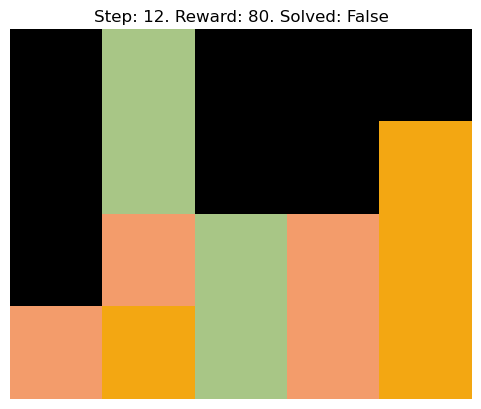

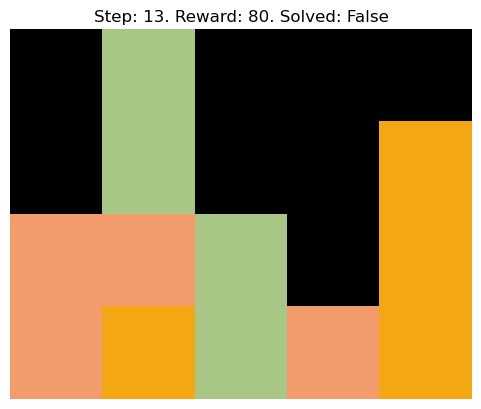

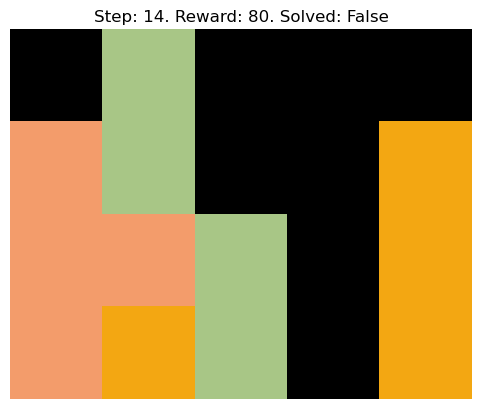

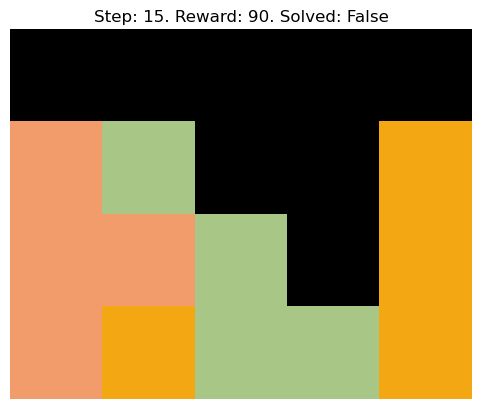

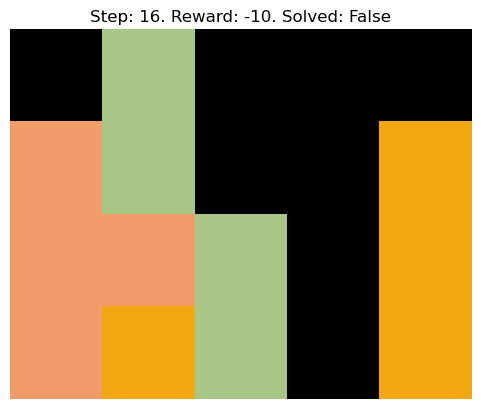

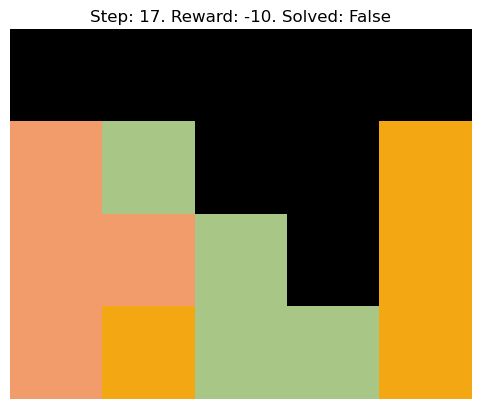

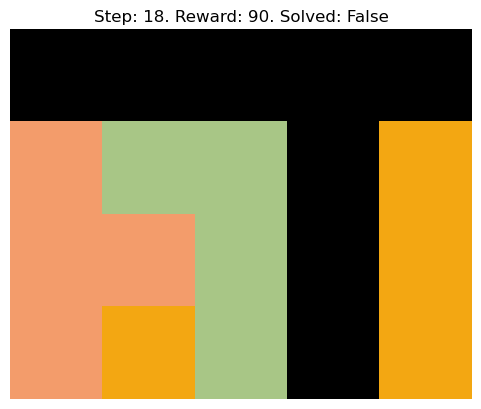

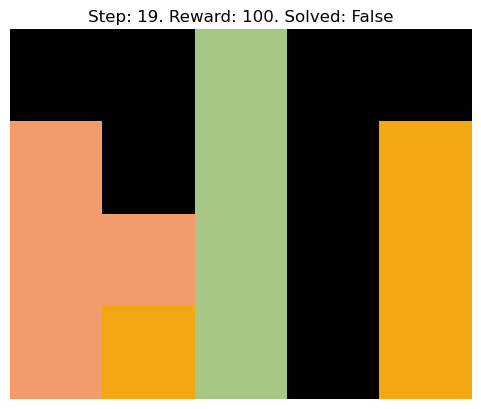

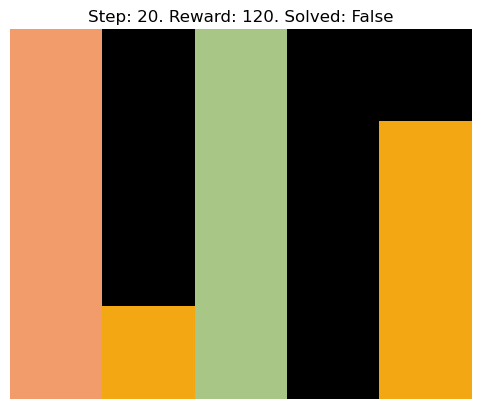

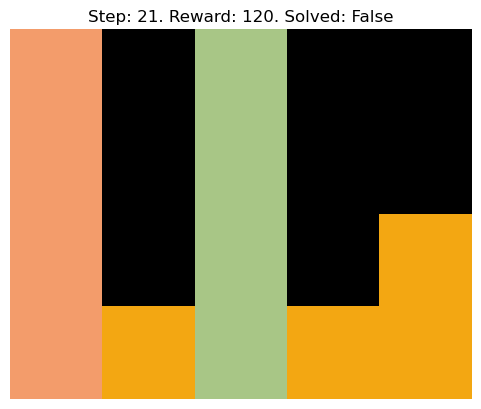

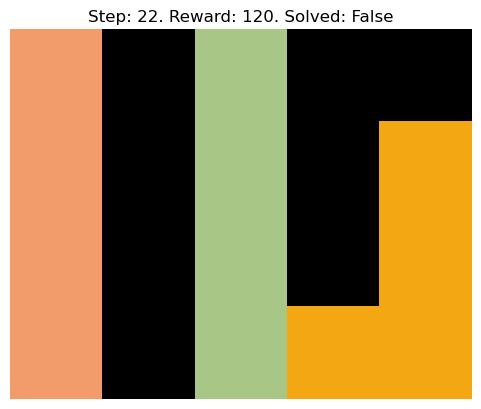

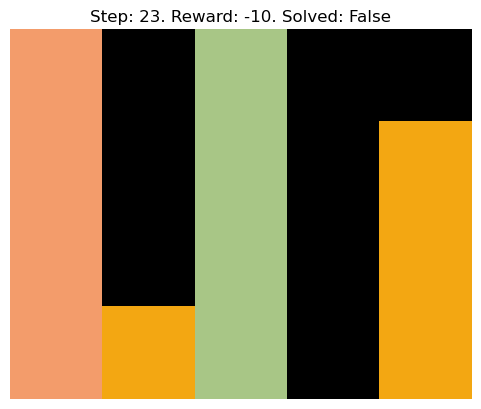

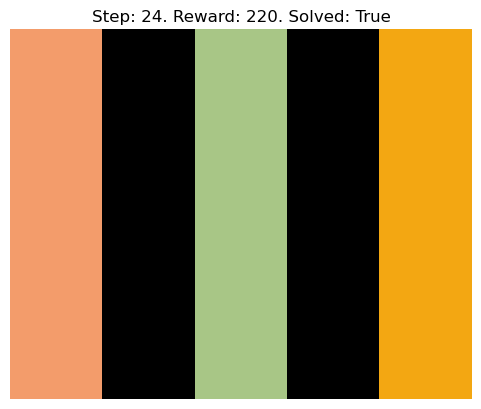

([array([[ 1,  2,  0,  1],
         [ 0,  1,  2,  0],
         [ 2,  0,  1,  2],
         [-1, -1, -1, -1],
         [-1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0,  1],
         [ 0,  1,  2, -1],
         [ 2,  0,  1,  2],
         [-1, -1, -1, -1],
         [ 0, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0,  1],
         [ 0,  1,  2,  2],
         [ 2,  0,  1, -1],
         [-1, -1, -1, -1],
         [ 0, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0,  1],
         [ 0,  1,  2,  2],
         [ 2,  0, -1, -1],
         [ 1, -1, -1, -1],
         [ 0, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0,  1],
         [ 0,  1,  2,  2],
         [ 2,  0,  0, -1],
         [ 1, -1, -1, -1],
         [-1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0, -1],
         [ 0,  1,  2,  2],
         [ 2,  0,  0, -1],
         [ 1,  1, -1, -1],
         [-1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0,  0],
         [ 0,  1,  2,  2],
         [ 2,  0, -1, -1],
         [ 1,  1, -

In [41]:
pg.evaluate(True)

In [ ]:
fig = plt.figure()
im = plt.imshow(states[0].T[::-1], cmap=dqn.env.cmap)
plt.title(f"Iteration: {0}")
plt.axis("off")


def init():
    im.set_data(states[0].T[::-1])


def animate(i):
    plt.title(f"Iteration: {i}")
    im.set_data(states[i].T[::-1])
    return im


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(states), interval=5)
anim.save

In [94]:
states[0]

([[0, 1, 2, 3, 0, 1, 2, 3],
  [0, 1, 2, 3, 0, 1, 2, 3],
  [0, 1, 2, 3, 0, 1, 2, 3],
  [0, 1, 2, 3, 0, 1, 2, 3]],
 697)

In [93]:
{str(i) for i in states}.pop()

'([[0, 1, 2, 3, 0, 1, 2, 3], [0, 1, 2, 3, 0, 1, 2, 3], [0, 1, 2, 3, 0, 1, 2, 3], [0, 1, 2, 3, 0, 1, 2, 3]], 697)'

In [ ]:
solvable = {}
s = 0
E = 2

for L in range(2, 10):
    for C in range(2, 13):
        A = list(range(C)) * L
        arr = np.array(A).reshape(C, L)
        states = []
        board = Board(C, L, E)

        for i in range(100*C):
            np.random.shuffle(arr)
            board.state_to_grid(arr.tolist())
            if not board.is_invalid_init_state():
                solved, steps, path = board.dfs_solve()
                if solved:
                    states.append((arr.tolist(), steps))
        solvable[(C, L, E)] = {str(i) for i in states}
        s += len(solvable[(C, L, E)])
        print((C, L, E), len(solvable[(C, L, E)]), s)

        with open("config.py", "w") as f:
            f.write("solvable =" + str(solvable).replace("'", '').replace('"', ''))

(2, 2, 2) 1 1
(3, 2, 2) 6 7
(4, 2, 2) 6 13
(5, 2, 2) 117 130
(6, 2, 2) 90 220
(7, 2, 2) 659 879
(8, 2, 2) 681 1560
(9, 2, 2) 898 2458
(10, 2, 2) 993 3451
(11, 2, 2) 1100 4551
(12, 2, 2) 1200 5751
(2, 3, 2) 2 5753
(3, 3, 2) 1 5754
(4, 3, 2) 24 5778
(5, 3, 2) 119 5897
(6, 3, 2) 20 5917
(7, 3, 2) 648 6565
(8, 3, 2) 789 7354
(9, 3, 2) 697 8051
(10, 3, 2) 1000 9051
(11, 3, 2) 1100 10151
